In [1]:
using Polynomials
push!(LOAD_PATH, pwd())
using Controlz
using Test
using DifferentialEquations
using Logging
using DataFrames
using LaTeXStrings
using PyPlot
PyPlot.matplotlib.style.use("hipster.mplstyle")

┌ Info: Precompiling Controlz [e034abe6-471a-4d54-96dd-ecd1f4022419]
└ @ Base loading.jl:1273


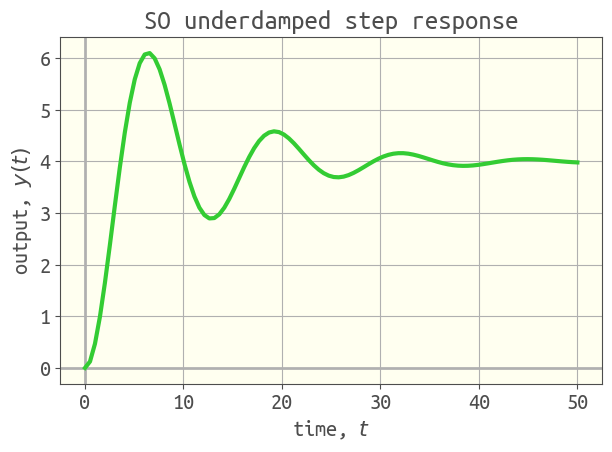

In [2]:
g = 4 / (4 * s ^ 2 + 0.8 * s + 1)
u = 1 / s
t, y = simulate(g * u, (0.0, 50.0))

viz_response(t, y, plot_title="SO underdamped step response")
savefig("../docs/src/example_response.png", format="png")

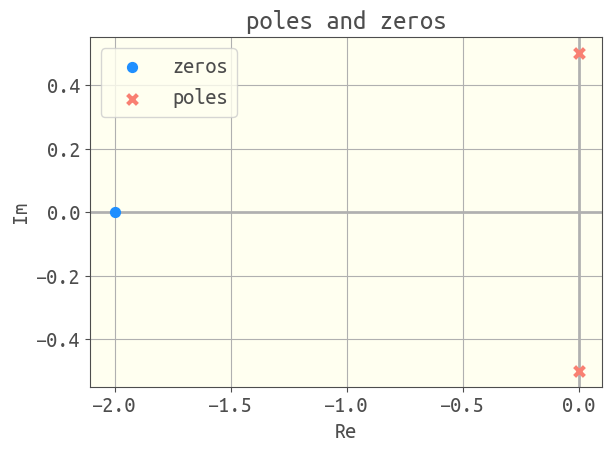

In [3]:
g = (s + 2) / (s^2 + 1/4)
viz_poles_and_zeros(g)
savefig("../docs/src/example_poles_and_zeros.png", format="png")

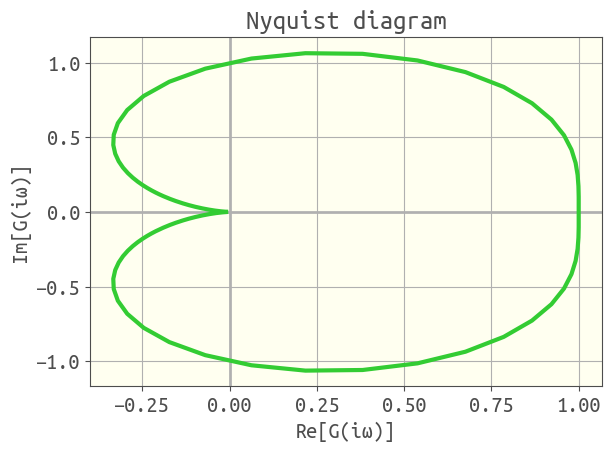

In [7]:
g = 1 / (s^2 + s + 1) # https://en.wikipedia.org/wiki/Nyquist_stability_criterion
nyquist_diagram(g)
savefig("../docs/src/example_nyquist.png", format="png")

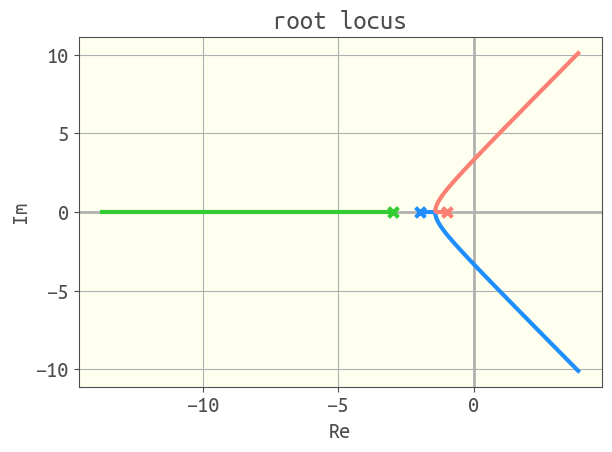

In [8]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)

root_locus(g_ol)
savefig("../docs/src/example_root_locus.png", format="png")

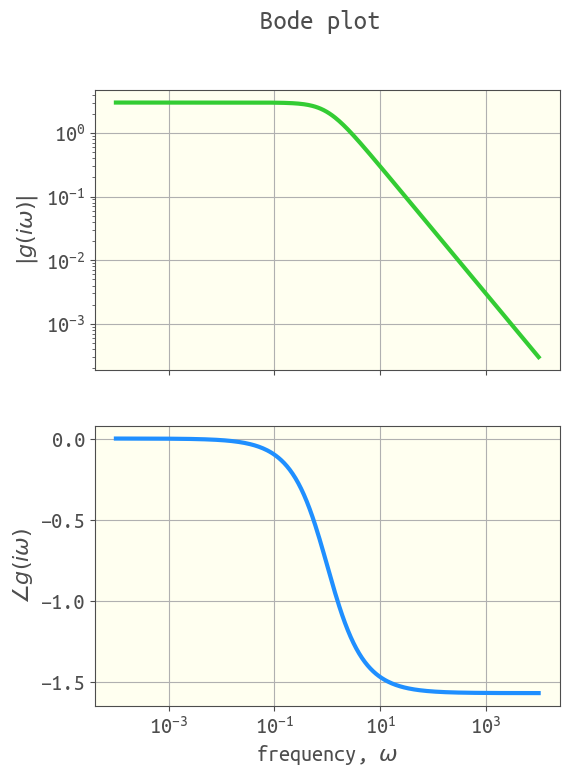

In [9]:
g = 3 / (s+1)

bode_plot(g)
savefig("../docs/src/example_bode.png", format="png")